In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix
import itertools

import keras 
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [2]:
skin_df = pd.read_csv('data/HAM10000_metadata.csv')
size=224
skin_df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [3]:
#label encoding
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

C:\Users\ompra\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


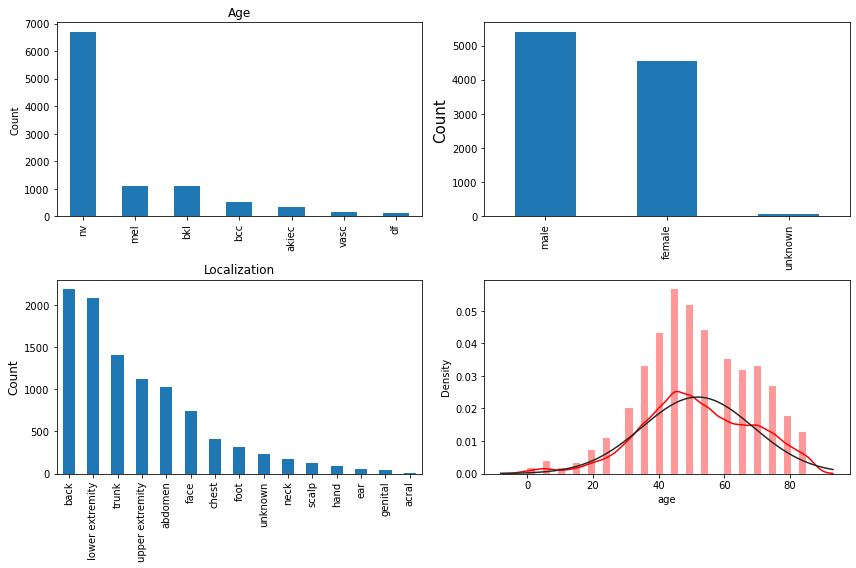

In [4]:
#data visualization
fig = plt.figure(figsize=(12,8))

ax1= fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar',ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2= fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar',ax=ax2)
ax2.set_ylabel('Count', size=15)
ax1.set_title('Sex');

ax3= fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count', size=12)
ax3.set_title('Localization');

ax4= fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax1.set_title('Age');

plt.tight_layout()
plt.show()

In [5]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [6]:
#balance data
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#combining into one df
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [7]:
#read all the images
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('data/','*', '*.jpg'))}

In [8]:
#add new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75)))) 

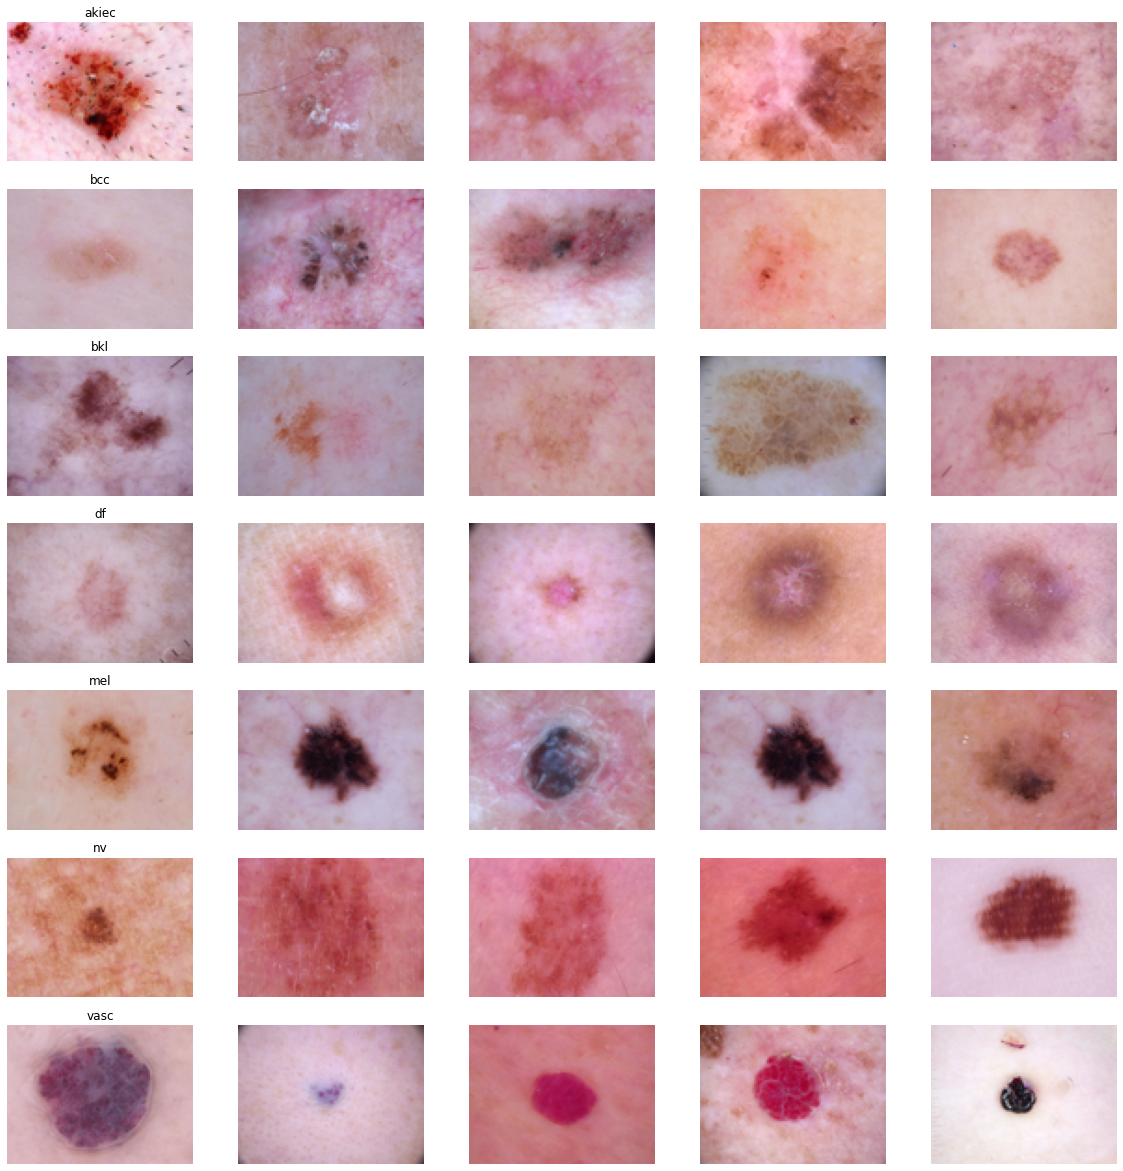

In [9]:
n_samples = 5
#plots
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [84]:
skin_df_balanced['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    3500
Name: image, dtype: int64

In [11]:
features=skin_df_balanced.drop(columns=['label'],axis=1)
target=skin_df_balanced['label']

In [12]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [13]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [14]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [15]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

# CNN MODEL ##


In [107]:
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 75, 100, 32)       896       
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 37, 50, 32)       0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 37, 50, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 37, 50, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 37, 50, 64)        36928     
                                                      

In [108]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [109]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["acc"])

In [110]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [111]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=False,  
        vertical_flip=False)  

datagen.fit(x_train)

In [112]:
epochs = 100
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/100
252/252 [==============================] - 5s 16ms/step - loss: 1.8093 - acc: 0.2647 - val_loss: 1.7233 - val_acc: 0.3821 - lr: 0.0010
Epoch 2/100
252/252 [==============================] - 4s 15ms/step - loss: 1.6278 - acc: 0.3611 - val_loss: 1.6483 - val_acc: 0.3714 - lr: 0.0010
Epoch 3/100
252/252 [==============================] - 4s 15ms/step - loss: 1.4757 - acc: 0.4044 - val_loss: 1.4650 - val_acc: 0.4536 - lr: 0.0010
Epoch 4/100
252/252 [==============================] - 4s 15ms/step - loss: 1.4104 - acc: 0.4429 - val_loss: 1.4090 - val_acc: 0.4750 - lr: 0.0010
Epoch 5/100
252/252 [==============================] - 4s 15ms/step - loss: 1.3282 - acc: 0.4766 - val_loss: 1.3633 - val_acc: 0.4821 - lr: 0.0010
Epoch 6/100
252/252 [==============================] - 4s 15ms/step - loss: 1.2819 - acc: 0.4948 - val_loss: 1.2547 - val_acc: 0.5286 - lr: 0.0010
Epoch 7/100
252/252 [==============================] - 4s 15ms/step - loss: 1.2281 - acc: 0.5115 - val_loss: 1.1862 - 

In [113]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 0s 8ms/step - loss: 0.7380 - acc: 0.7321
Validation: accuracy = 0.732143  ;  loss_v = 0.738047
Test: accuracy = 0.757143  ;  loss = 0.755897


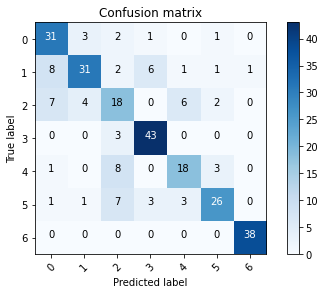

In [114]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## DENSENET201

In [115]:
import tensorflow as tf 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import*
from tensorflow.keras.applications import*
from tensorflow.keras.callbacks import*
from tensorflow.keras.initializers import* 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet201
from numpy.random import seed
from tensorflow.keras.layers import Input
from tensorflow.python.keras.layers import Lambda
from tensorflow.python.keras import backend as K

In [116]:
base_model = DenseNet201(input_shape=(75, 100, 3), include_top=False, weights="imagenet")

In [117]:
for layer in base_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
print(len(base_model.layers))

input_8
zero_padding2d_6
conv1/conv
conv1/bn
conv1/relu
zero_padding2d_7
pool1
conv2_block1_0_bn
conv2_block1_0_relu
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_concat
conv2_block2_0_bn
conv2_block2_0_relu
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_concat
conv2_block3_0_bn
conv2_block3_0_relu
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_concat
conv2_block4_0_bn
conv2_block4_0_relu
conv2_block4_1_conv
conv2_block4_1_bn
conv2_block4_1_relu
conv2_block4_2_conv
conv2_block4_concat
conv2_block5_0_bn
conv2_block5_0_relu
conv2_block5_1_conv
conv2_block5_1_bn
conv2_block5_1_relu
conv2_block5_2_conv
conv2_block5_concat
conv2_block6_0_bn
conv2_block6_0_relu
conv2_block6_1_conv
conv2_block6_1_bn
conv2_block6_1_relu
conv2_block6_2_conv
conv2_block6_concat
pool2_bn
pool2_relu
pool2_conv
pool2_pool
conv3_block1_0_bn
conv3_block1_0_relu
conv3_block1_1_conv
conv3

conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_concat
conv5_block4_0_bn
conv5_block4_0_relu
conv5_block4_1_conv
conv5_block4_1_bn
conv5_block4_1_relu
conv5_block4_2_conv
conv5_block4_concat
conv5_block5_0_bn
conv5_block5_0_relu
conv5_block5_1_conv
conv5_block5_1_bn
conv5_block5_1_relu
conv5_block5_2_conv
conv5_block5_concat
conv5_block6_0_bn
conv5_block6_0_relu
conv5_block6_1_conv
conv5_block6_1_bn
conv5_block6_1_relu
conv5_block6_2_conv
conv5_block6_concat
conv5_block7_0_bn
conv5_block7_0_relu
conv5_block7_1_conv
conv5_block7_1_bn
conv5_block7_1_relu
conv5_block7_2_conv
conv5_block7_concat
conv5_block8_0_bn
conv5_block8_0_relu
conv5_block8_1_conv
conv5_block8_1_bn
conv5_block8_1_relu
conv5_block8_2_conv
conv5_block8_concat
conv5_block9_0_bn
conv5_block9_0_relu
conv5_block9_1_conv
conv5_block9_1_bn
conv5_block9_1_relu
conv5_block9_2_conv
conv5_block9_concat
conv5_block10_0_bn
conv5_block10_0_relu
conv5_block10_1_conv
conv5_block10_1_bn
conv5_block10_1_relu
conv5_block10_2_conv
co

In [118]:
last_layer = base_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 2, 3, 1920)


In [119]:
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(base_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [120]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 81, 106, 3)  0           ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 38, 50, 64)   9408        ['zero_padding2d_6[0][0]']       
                                                                                            

 conv2_block4_1_conv (Conv2D)   (None, 19, 25, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 19, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 19, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 19, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 9, 12, 128)   20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 9, 12, 128)  512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 9, 12, 128)  0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 9, 12, 32)    36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 9, 12, 32)    36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 9, 12, 320)  0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 9, 12, 320)  1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 9, 12, 448)  1792        ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 9, 12, 448)  0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 9, 12, 128)   57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 9, 12, 128)  512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 4, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 4, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 4, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 4, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 4, 6, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 4, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 4, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 4, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 4, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 4, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 4, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 4, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 4, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 4, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 4, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 4, 6, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 4, 6, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block29_0_relu (Activati  (None, 4, 6, 1152)  0           ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 4, 6, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block33_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 4, 6, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 4, 6, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 4, 6, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 4, 6, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 4, 6, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 4, 6, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block42_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 4, 6, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 4, 6, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 2, 3, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 2, 3, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 2, 3, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 2, 3, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 2, 3, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 2, 3, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 2, 3, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 2, 3, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization) 

 conv5_block11_1_conv (Conv2D)  (None, 2, 3, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 2, 3, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 2, 3, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 2, 3, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 2, 3, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 2, 3, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 2, 3, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block24_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 2, 3, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 2, 3, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
          

                                                                                                  
 conv5_block28_concat (Concaten  (None, 2, 3, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 2, 3, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 2, 3, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 global_max_pooling2d_4 (Global  (None, 1920)        0           ['relu[0][0]']                   
 MaxPooling2D)                                                                                    
                                                                                                  
 dense_14 (Dense)               (None, 512)          983552      ['global_max_pooling2d_4[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)           (None, 512)          0           ['dense_14[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 7)            3591        ['dropout_13[0][0]']             
                                                                                                  
Total para

In [121]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_validate)

In [122]:
batch_size = 32
epochs = 100
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size), 
                              validation_steps=(x_validate.shape[0] // batch_size))

Epoch 1/100
78/78 [==============================] - 30s 173ms/step - loss: 2.4798 - accuracy: 0.2239 - val_loss: 18752.9473 - val_accuracy: 0.1406
Epoch 2/100
78/78 [==============================] - 11s 139ms/step - loss: 1.8496 - accuracy: 0.3396 - val_loss: 4.3595 - val_accuracy: 0.2500
Epoch 3/100
78/78 [==============================] - 11s 143ms/step - loss: 1.5621 - accuracy: 0.4337 - val_loss: 1.5492 - val_accuracy: 0.4297
Epoch 4/100
78/78 [==============================] - 11s 145ms/step - loss: 1.4454 - accuracy: 0.4678 - val_loss: 1.2977 - val_accuracy: 0.4922
Epoch 5/100
78/78 [==============================] - 12s 147ms/step - loss: 1.2949 - accuracy: 0.5205 - val_loss: 1.2086 - val_accuracy: 0.5273
Epoch 6/100
78/78 [==============================] - 12s 147ms/step - loss: 1.2220 - accuracy: 0.5382 - val_loss: 1.1736 - val_accuracy: 0.5469
Epoch 7/100
78/78 [==============================] - 12s 148ms/step - loss: 1.1970 - accuracy: 0.5531 - val_loss: 1.0883 - val_accur

In [123]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 1s 58ms/step - loss: 0.5203 - accuracy: 0.8357
Validation: accuracy = 0.835714  ;  loss_v = 0.520262
Test: accuracy = 0.845714  ;  loss = 0.521962


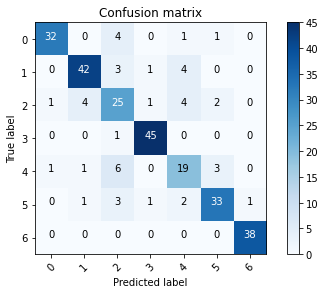

In [124]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

In [125]:
base_model.layers[481].name

'conv5_block1_0_bn'

In [126]:
for layer in base_model.layers[481:]:
    layer.trainable = True

In [127]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [128]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [129]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 75, 100, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 81, 106, 3)  0           ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 38, 50, 64)   9408        ['zero_padding2d_6[0][0]']       
                                                                                            

 conv2_block4_1_conv (Conv2D)   (None, 19, 25, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 19, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 19, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 19, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 9, 12, 128)   20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 9, 12, 128)  512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 9, 12, 128)  0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 9, 12, 32)    36864       ['conv3_block2_1_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 9, 12, 32)    36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 9, 12, 320)  0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 9, 12, 320)  1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_blo

 conv3_block11_0_bn (BatchNorma  (None, 9, 12, 448)  1792        ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 9, 12, 448)  0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 9, 12, 128)   57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 9, 12, 128)  512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 4, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 4, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 4, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 4, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization) 

 conv4_block7_1_conv (Conv2D)   (None, 4, 6, 128)    57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 4, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 4, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 4, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 4, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 4, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 4, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 4, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 4, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block20_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 4, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
          

                                                                                                  
 conv4_block24_concat (Concaten  (None, 4, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 4, 6, 1024)  4096        ['conv4_block24_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block25_0_relu (Activati  (None, 4, 6, 1024)  0           ['conv4_block25_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block29_0_relu (Activati  (None, 4, 6, 1152)  0           ['conv4_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 4, 6, 128)    147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block29_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block29_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block33_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 4, 6, 1312)  0           ['conv4_block32_concat[0][0]',   
 ate)                                                             'conv4_block33_2_conv[0][0]']   
                                                                                                  
 conv4_block34_0_bn (BatchNorma  (None, 4, 6, 1312)  5248        ['conv4_block33_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 4, 6, 1440)  5760        ['conv4_block37_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 4, 6, 1440)  0           ['conv4_block38_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block38_1_conv (Conv2D)  (None, 4, 6, 128)    184320      ['conv4_block38_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 4, 6, 128)    200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 4, 6, 128)   512         ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 4, 6, 128)   0           ['conv4_block42_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block42_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block42_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 4, 6, 32)     36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 4, 6, 1728)  0           ['conv4_block45_concat[0][0]',   
 ate)                                                             'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_block47_0_bn (BatchNorma  (None, 4, 6, 1728)  6912        ['conv4_block46_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv5_block2_1_relu (Activatio  (None, 2, 3, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 2, 3, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_concat (Concatena  (None, 2, 3, 960)   0           ['conv5_block1_concat[0][0]',    
 te)                                                              'conv5_block2_2_conv[0][0]']    
                                                                                                  
 conv5_block3_0_bn (BatchNormal  (None, 2, 3, 960)   3840        ['conv5_block2_concat[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 2, 3, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 2, 3, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, 2, 3, 128)    139264      ['conv5_block7_0_relu[0][0]']    
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, 2, 3, 128)   512         ['conv5_block7_1_conv[0][0]']    
 ization) 

 conv5_block11_1_conv (Conv2D)  (None, 2, 3, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block11_1_relu (Activati  (None, 2, 3, 128)   0           ['conv5_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block11_1_relu[0][0]']   
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 2, 3, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
                                                                                                  
 conv5_block16_0_bn (BatchNorma  (None, 2, 3, 1376)  5504        ['conv5_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block16_0_relu (Activati  (None, 2, 3, 1376)  0           ['conv5_block16_0_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 2, 3, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block20_1_conv (Conv2D)  (None, 2, 3, 128)    192512      ['conv5_block20_0_relu[0][0]']   
                                                                                                  
 conv5_block20_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block24_1_bn (BatchNorma  (None, 2, 3, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 2, 3, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_2_conv (Conv2D)  (None, 2, 3, 32)     36864       ['conv5_block24_1_relu[0][0]']   
                                                                                                  
 conv5_block24_concat (Concaten  (None, 2, 3, 1664)  0           ['conv5_block23_concat[0][0]',   
 ate)                                                             'conv5_block24_2_conv[0][0]']   
          

                                                                                                  
 conv5_block28_concat (Concaten  (None, 2, 3, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 2, 3, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block29_0_relu (Activati  (None, 2, 3, 1792)  0           ['conv5_block29_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

                                                                                                  
 global_max_pooling2d_4 (Global  (None, 1920)        0           ['relu[0][0]']                   
 MaxPooling2D)                                                                                    
                                                                                                  
 dense_14 (Dense)               (None, 512)          983552      ['global_max_pooling2d_4[0][0]'] 
                                                                                                  
 dropout_13 (Dropout)           (None, 512)          0           ['dense_14[0][0]']               
                                                                                                  
 dense_15 (Dense)               (None, 7)            3591        ['dropout_13[0][0]']             
                                                                                                  
Total para

In [130]:
batch_size = 32
epochs = 100
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_validate.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])


Epoch 1/100
78/78 [==============================] - 33s 196ms/step - loss: 0.2470 - acc: 0.9068 - val_loss: 0.5130 - val_acc: 0.8594 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 12s 159ms/step - loss: 0.2051 - acc: 0.9204 - val_loss: 0.5472 - val_acc: 0.8594 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 13s 167ms/step - loss: 0.2102 - acc: 0.9240 - val_loss: 0.5607 - val_acc: 0.8398 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.2197 - acc: 0.9248
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
78/78 [==============================] - 13s 168ms/step - loss: 0.2197 - acc: 0.9248 - val_loss: 0.5250 - val_acc: 0.8281 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - 13s 165ms/step - loss: 0.1851 - acc: 0.9293 - val_loss: 0.5885 - val_acc: 0.8203 - lr: 5.0000e-05
Epoch 6/100
78/78 [==============================] - 13s 164ms/step - loss: 0.1545 - acc: 0

Epoch 48/100
78/78 [==============================] - 13s 162ms/step - loss: 0.0633 - acc: 0.9815 - val_loss: 0.5992 - val_acc: 0.8438 - lr: 1.0000e-06
Epoch 49/100
78/78 [==============================] - 13s 162ms/step - loss: 0.0832 - acc: 0.9695 - val_loss: 0.5747 - val_acc: 0.8594 - lr: 1.0000e-06
Epoch 50/100
78/78 [==============================] - 13s 162ms/step - loss: 0.0716 - acc: 0.9723 - val_loss: 0.5341 - val_acc: 0.8633 - lr: 1.0000e-06
Epoch 51/100
78/78 [==============================] - 13s 162ms/step - loss: 0.0731 - acc: 0.9795 - val_loss: 0.5883 - val_acc: 0.8516 - lr: 1.0000e-06
Epoch 52/100
78/78 [==============================] - 13s 162ms/step - loss: 0.0740 - acc: 0.9771 - val_loss: 0.5552 - val_acc: 0.8594 - lr: 1.0000e-06
Epoch 53/100
78/78 [==============================] - 13s 163ms/step - loss: 0.0709 - acc: 0.9751 - val_loss: 0.6119 - val_acc: 0.8398 - lr: 1.0000e-06
Epoch 54/100
78/78 [==============================] - 13s 164ms/step - loss: 0.0698 - ac

In [131]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 1s 59ms/step - loss: 0.5827 - acc: 0.8500
Validation: accuracy = 0.850000  ;  loss_v = 0.582674
Test: accuracy = 0.855714  ;  loss = 0.560725


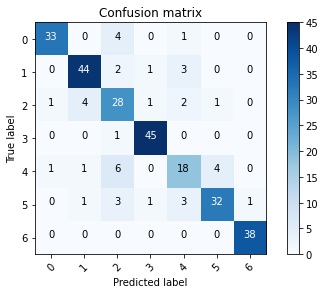

In [132]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## VGG16

In [133]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn import *
pre_trained_model2 = VGG16(input_shape=(75, 100, 3), include_top=False, weights="imagenet")

In [134]:
for layer in pre_trained_model2.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model2.layers))

input_9
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [135]:
last_layer = pre_trained_model2.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 2, 3, 512)


In [136]:
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(pre_trained_model2.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [137]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [138]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 75, 100, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 75, 100, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 75, 100, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 37, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 37, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 37, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 25, 128)       0   

In [139]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_validate)

In [140]:
batch_size = 32
epochs = 100
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size), 
                              validation_steps=(x_validate.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/100
78/78 [==============================] - 6s 67ms/step - loss: 2.0679 - acc: 0.2014 - val_loss: 1.7336 - val_acc: 0.3398 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 5s 65ms/step - loss: 1.7722 - acc: 0.3063 - val_loss: 1.6322 - val_acc: 0.3906 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 5s 65ms/step - loss: 1.6164 - acc: 0.3794 - val_loss: 1.5217 - val_acc: 0.4570 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - 5s 64ms/step - loss: 1.5301 - acc: 0.4204 - val_loss: 1.4604 - val_acc: 0.4688 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - 5s 65ms/step - loss: 1.4573 - acc: 0.4542 - val_loss: 1.4299 - val_acc: 0.4531 - lr: 1.0000e-04
Epoch 6/100
78/78 [==============================] - 5s 68ms/step - loss: 1.4070 - acc: 0.4795 - val_loss: 1.3714 - val_acc: 0.5352 - lr: 1.0000e-04
Epoch 7/100
78/78 [==============================] - 5s 69ms/step - loss: 1.3734 - acc: 0.4891 - val_loss:

In [141]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 0s 37ms/step - loss: 1.1657 - acc: 0.5821
Validation: accuracy = 0.582143  ;  loss_v = 1.165673
Test: accuracy = 0.591429  ;  loss = 1.118474


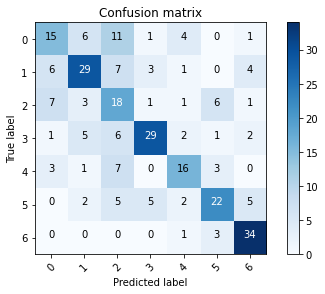

In [142]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

# FINE TUNNING

In [143]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [144]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [145]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [146]:
batch_size = 32
epochs = 100
history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                              validation_steps=(x_validate.shape[0] // batch_size), callbacks=[learning_rate_reduction])

C:\Users\ompra\AppData\Local\Temp/ipykernel_10160/1485503954.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/100
78/78 [==============================] - 6s 68ms/step - loss: 1.1514 - acc: 0.5727 - val_loss: 1.1199 - val_acc: 0.6133 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 5s 67ms/step - loss: 0.9464 - acc: 0.6310 - val_loss: 0.8652 - val_acc: 0.6797 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 5s 68ms/step - loss: 0.8462 - acc: 0.6732 - val_loss: 0.8599 - val_acc: 0.6641 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - 5s 68ms/step - loss: 0.7390 - acc: 0.7178 - val_loss: 0.7812 - val_acc: 0.6836 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - 5s 68ms/step - loss: 0.6949 - acc: 0.7351 - val_loss: 0.7348 - val_acc: 0.7266 - lr: 1.0000e-04
Epoch 6/100
78/78 [==============================] - 5s 67ms/step - loss: 0.6719 - acc: 0.7496 - val_loss: 0.6772 - val_acc: 0.7734 - lr: 1.0000e-04
Epoch 7/100
78/78 [==============================] - 5s 68ms/step - loss: 0.5742 - acc: 0.7838 - val_loss:

In [147]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 0s 37ms/step - loss: 0.6437 - acc: 0.8321
Validation: accuracy = 0.832143  ;  loss_v = 0.643675
Test: accuracy = 0.841429  ;  loss = 0.641409


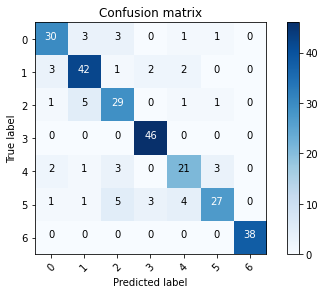

In [148]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## EfficientnetB


In [157]:
pre_trained_model3 =EfficientNetB7(input_shape=(75, 100, 3), include_top=False, weights="imagenet")

In [158]:
for layer in pre_trained_model3.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model3.layers))

input_11
rescaling_1
normalization_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block1b_dwconv
block1b_bn
block1b_activation
block1b_se_squeeze
block1b_se_reshape
block1b_se_reduce
block1b_se_expand
block1b_se_excite
block1b_project_conv
block1b_project_bn
block1b_drop
block1b_add
block1c_dwconv
block1c_bn
block1c_activation
block1c_se_squeeze
block1c_se_reshape
block1c_se_reduce
block1c_se_expand
block1c_se_excite
block1c_project_conv
block1c_project_bn
block1c_drop
block1c_add
block1d_dwconv
block1d_bn
block1d_activation
block1d_se_squeeze
block1d_se_reshape
block1d_se_reduce
block1d_se_expand
block1d_se_excite
block1d_project_conv
block1d_project_bn
block1d_drop
block1d_add
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
bloc

In [159]:
last_layer = pre_trained_model2.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 2, 3, 512)


In [160]:
x = GlobalMaxPooling2D()(last_layer.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(pre_trained_model2.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [161]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [162]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(x_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(x_validate)

In [163]:
batch_size = 32
epochs = 100
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                              verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size), 
                              validation_steps=(x_validate.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

Epoch 1/100
78/78 [==============================] - 5s 55ms/step - loss: 0.9717 - acc: 0.6435 - val_loss: 0.6858 - val_acc: 0.7734 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 4s 51ms/step - loss: 0.5256 - acc: 0.8043 - val_loss: 0.5907 - val_acc: 0.7891 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 4s 52ms/step - loss: 0.4095 - acc: 0.8521 - val_loss: 0.7320 - val_acc: 0.7695 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - 4s 52ms/step - loss: 0.3810 - acc: 0.8645 - val_loss: 0.6563 - val_acc: 0.7852 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - ETA: 0s - loss: 0.3550 - acc: 0.8782
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
78/78 [==============================] - 4s 52ms/step - loss: 0.3550 - acc: 0.8782 - val_loss: 0.6177 - val_acc: 0.7852 - lr: 1.0000e-04
Epoch 6/100
78/78 [==============================] - 4s 53ms/step - loss: 0.2545 - acc: 0.9148 - val_

In [164]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 0s 30ms/step - loss: 0.6815 - acc: 0.8714
Validation: accuracy = 0.871429  ;  loss_v = 0.681476
Test: accuracy = 0.838571  ;  loss = 0.724581


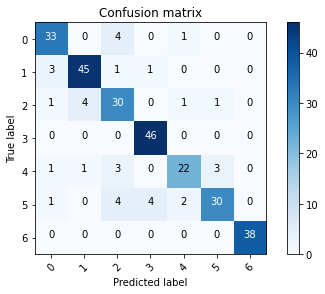

In [165]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

## FINE TUNNING FOR EFFICEINTNETB7

In [167]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

In [168]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

C:\Users\ompra\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [169]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [171]:
batch_size = 32
epochs = 100
history = model.fit(train_datagen.flow(x_train,y_train, batch_size=batch_size),
                    epochs = epochs, validation_data = val_datagen.flow(x_validate, y_validate),
                    verbose = 1, steps_per_epoch=(x_train.shape[0] // batch_size),
                    validation_steps=(x_validate.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/100
78/78 [==============================] - 5s 56ms/step - loss: 0.1854 - acc: 0.9361 - val_loss: 0.6677 - val_acc: 0.8398 - lr: 1.0000e-04
Epoch 2/100
78/78 [==============================] - 4s 56ms/step - loss: 0.1370 - acc: 0.9538 - val_loss: 0.8030 - val_acc: 0.8125 - lr: 1.0000e-04
Epoch 3/100
78/78 [==============================] - 5s 58ms/step - loss: 0.1588 - acc: 0.9461 - val_loss: 0.7677 - val_acc: 0.8203 - lr: 1.0000e-04
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.1911 - acc: 0.9357
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
78/78 [==============================] - 5s 58ms/step - loss: 0.1911 - acc: 0.9357 - val_loss: 0.8817 - val_acc: 0.8164 - lr: 1.0000e-04
Epoch 5/100
78/78 [==============================] - 5s 59ms/step - loss: 0.1117 - acc: 0.9646 - val_loss: 0.8193 - val_acc: 0.8203 - lr: 5.0000e-05
Epoch 6/100
78/78 [==============================] - 5s 59ms/step - loss: 0.0677 - acc: 0.9771 - val_

In [172]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

9/9 [==============================] - 0s 35ms/step - loss: 0.8698 - acc: 0.8607
Validation: accuracy = 0.860714  ;  loss_v = 0.869796
Test: accuracy = 0.851429  ;  loss = 0.918948


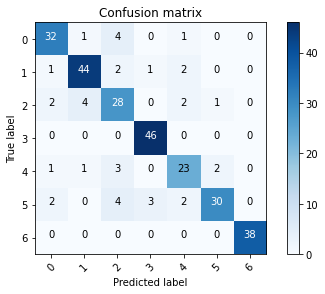

In [173]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 